In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore


import requests
import zipfile
import io
import warnings


warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

season_start='2024-11-17 06:00:00'
season_end='2025-04-01 00:00:00'

Opening datasets (separate data from SCADA, Thermionyx and Davis meteo station) from GitHub.

In [2]:
import os
import shutil

# Download the zip file from GitHub
url_scada = "https://github.com/xai4heat/xai4heat/raw/main/datasets/scada_data_2024-25.zip"
#url_thermionyx = "https://github.com/xai4heat/xai4heat/raw/main/datasets/thermionyx_data_2024-25.zip"
url_thermionyx = "https://github.com/xai4heat/xai4heat/raw/main/datasets/thermionyx_data_2024-25_1min.zip"
url_davis = "https://github.com/xai4heat/xai4heat/raw/main/datasets/weather/weather_davis_2025.zip"

response_scada = requests.get(url_scada)
response_thermionyx = requests.get(url_thermionyx)
response_davis = requests.get(url_davis)

with zipfile.ZipFile(io.BytesIO(response_scada.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dfs = pd.read_csv(f)

with zipfile.ZipFile(io.BytesIO(response_thermionyx.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dft = pd.read_csv(f)

with zipfile.ZipFile(io.BytesIO(response_davis.content)) as z:
    z.extractall("weather_davis_2025")
    txt_file_path = os.path.join("weather_davis_2025", "weather_davis_2025.txt")
    dfd = pd.read_csv(txt_file_path, delimiter='\t', skiprows=1)

os.remove(txt_file_path)
shutil.rmtree('weather_davis_2025')

Processing Thermionyx data

Creating datetime index on datetime. Sorting on datetime index ascending.
In dft dataframe, name column stores data in format <block name>_<building number>_<apartment number>. There are some names with added _CO2 at the end of the value.
In dataframe, we create columns block_name, building_number and apartment_number. For those with added _CO2, we create separate column with name sensor_co2 which stores binary values - true if _CO2 is added, false if not.

In [3]:
dft['datetime'] = pd.to_datetime(dft['datetime'])
dft.set_index('datetime', inplace=True)
dft.sort_index(inplace=True)

dft['sensor_co2'] = dft['name'].str.endswith('_CO2')
name_parts = dft['name'].str.replace('_CO2$', '', regex=True).str.split('_', expand=True)
dft['block_name'] = name_parts[0]
dft['building_number'] = name_parts[1]
dft['apartment_number'] = name_parts[2]

dft.drop(columns=['probe_id', 'name'], inplace=True)

Based on below, it appears that there are some disturbingly large differences in measuring temperature and relative_humidity on hub and remote devices, hub devices are those with sensor_co2=True. In overall, hub devices measure more than 10% higher temperature and less than 10% lower humidity. Another problem is that measurements by hub and remote devices are not done at the same time.

Addressing the above:
Given that there are fewer hubs then remote devices, our approach would be to disregard measurements of temperature and relative humidity by hub devices, but to consider only co2 measurements.

Mean is used for downsampling. This downsamples time-series data to 15-minute intervals by grouping data into 15-minute buckets and computing the mean of all values in each bucket.

In [4]:
dft[(dft['block_name'] == 'L12') & (dft['building_number'] == '19') & (dft['apartment_number'] == '2')].head(10)

,temperature,relative_humidity,co2,sensor_co2,block_name,building_number,apartment_number
datetime,,,,,,,
2024-11-05 19:43:18,24.10,36.10,NaN,False,L12,19,2
2024-11-05 19:43:24,22.94,40.45,877.0,True,L12,19,2
2024-11-05 19:44:24,23.02,39.91,870.0,True,L12,19,2
2024-11-05 19:45:28,23.06,39.11,787.0,True,L12,19,2
2024-11-05 19:46:29,23.15,38.67,732.0,True,L12,19,2
2024-11-05 19:47:30,23.16,38.39,706.0,True,L12,19,2
2024-11-05 19:48:20,23.90,34.80,NaN,False,L12,19,2
2024-11-05 19:48:29,23.20,38.07,684.0,True,L12,19,2
2024-11-05 19:49:34,23.28,37.88,656.0,True,L12,19,2


Create a hierarchical structure block_name -> building_number -> apartment_number.

In [5]:
thermionyx_hierarchy = {}
for _, row in dft.reset_index().iterrows():
    block = row['block_name']
    building = row['building_number']
    apartment = row['apartment_number']
    thermionyx_hierarchy.setdefault(block, {}).setdefault(building, set()).add(apartment)

# Convert sets to sorted lists for easier use
for block in thermionyx_hierarchy:
    for building in thermionyx_hierarchy[block]:
        thermionyx_hierarchy[block][building] = sorted(thermionyx_hierarchy[block][building])

Get all Thermionycs data in location_groups_t

In [7]:
location_groups_t = {}

merged_all = None

for block_name, buildings in thermionyx_hierarchy.items():
    print(f"Block: {block_name}")
    for building_number, apartments in buildings.items():
        print(f"  Building: {building_number}")
        print(f"    Apartments: {', '.join(apartments)}")

        for apartment_number in apartments:
            ff1=dft[(dft['block_name'] == block_name) & (dft['building_number'] == building_number) & (dft['apartment_number'] == apartment_number) & (dft['sensor_co2'] == False)][['temperature', 'relative_humidity']].resample('15min').mean()
            ff2=dft[(dft['block_name'] == block_name) & (dft['building_number'] == building_number) & (dft['apartment_number'] == apartment_number) & (dft['sensor_co2'] == True)][['co2']].resample('15min').mean()
            ff1 = ff1.rename(columns=lambda col: f"{col}_{building_number}_{apartment_number}")
            ff2 = ff2.rename(columns=lambda col: f"{col}_{building_number}_{apartment_number}")
            merged = pd.merge(ff1, ff2, left_index=True, right_index=True, how='outer')

            if merged_all is None:
                merged_all = merged
            else:
                merged_all = pd.merge(merged_all, merged, left_index=True, right_index=True, how='outer')

    merged_all.dropna(axis=1, how='all', inplace=True)
    location_groups_t['TPS Lamela '+block_name] = merged_all
    merged_all = None


Block: L4
  Building: 37
    Apartments: 12, 15, 2, 4, 9
Block: L17
  Building: 35
    Apartments: 11, 16, 2, 5, 7
Block: L8
  Building: 53
    Apartments: 12, 13, 2, 20, 8
Block: L12
  Building: 21
    Apartments: 18, 2
  Building: 19
    Apartments: 1, 18, 2


In [8]:
location_groups_t['TPS Lamela L12'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15378 entries, 2024-11-05 19:30:00 to 2025-04-14 23:45:00
Freq: 15min
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   temperature_21_18        10443 non-null  float64
 1   relative_humidity_21_18  10443 non-null  float64
 2   temperature_21_2         14837 non-null  float64
 3   relative_humidity_21_2   14837 non-null  float64
 4   temperature_19_1         15354 non-null  float64
 5   relative_humidity_19_1   15354 non-null  float64
 6   temperature_19_18        15350 non-null  float64
 7   relative_humidity_19_18  15350 non-null  float64
 8   temperature_19_2         15371 non-null  float64
 9   relative_humidity_19_2   15371 non-null  float64
 10  co2_19_2                 15371 non-null  float64
dtypes: float64(11)
memory usage: 1.4 MB


Processing Davis meteo station weather data.

In [9]:
dfd['Time'] = dfd['Time'].str.replace(' a', ' AM').str.replace(' p', ' PM')
dfd['datetime'] = pd.to_datetime(dfd['Date'] + ' ' + dfd['Time'], format='%m/%d/%y %I:%M %p')

dfd.set_index('datetime', inplace=True)
dfd.drop(columns=['Date', 'Time'], inplace=True)

dfd = dfd[~dfd.index.duplicated(keep='first')]
dfd = dfd.resample('15min').first().dropna(how='all')
dfd.sort_index(inplace=True)

dfd.columns = ['davis_' + col for col in dfd.columns]
dfd.columns = [col.lower().replace('.', '_').replace(' ', '_') for col in dfd.columns]

for col in dfd.columns:
    dfd[col] = pd.to_numeric(dfd[col], errors='coerce')


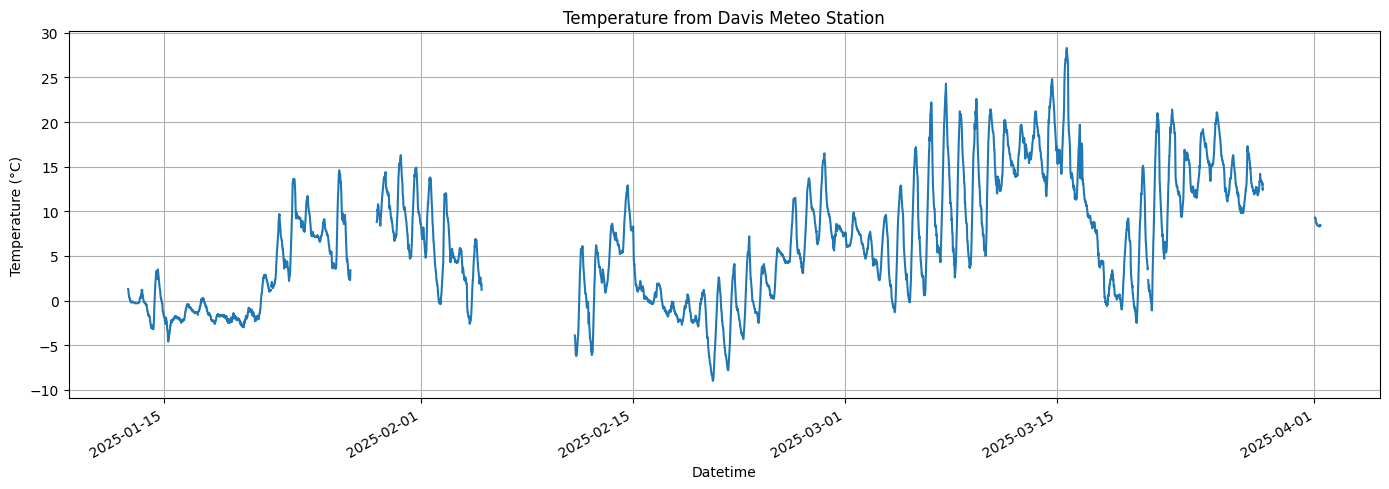

In [10]:
dfd['davis_temp'].plot(figsize=(14, 5), title='Temperature from Davis Meteo Station')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

Opening dataset with weather forecast data previously dowonloaded from Visual Crossing Weather Data, stored on project's GitHub repo. Setting datetime index, removing unnecessary columns.



In [11]:
weather_url = "https://github.com/xai4heat/xai4heat/raw/refs/heads/main/datasets/weather/weather_2024_25.txt"
dfw = pd.read_csv(weather_url)

dfw['datetime'] = pd.to_datetime(dfw['datetime'])
dfw.set_index('datetime',inplace=True)

# Removing irrelevant data
dfw=dfw.drop(['name',
              'preciptype',
              'icon',
              'stations',
              'severerisk',
              'conditions'], axis=1)

date_range_season = (dfw.index >= pd.to_datetime(season_start)) & (dfw.index < pd.to_datetime(season_end))
dfw = dfw[date_range_season].copy()

dfw.columns = ['forecast_' + col for col in dfw.columns]
dfw.columns = [col.lower().replace('.', '_').replace(' ', '_') for col in dfw.columns]

Create a dictionary with datasets for each of the blocks (L4, L8, L12, L17, L22), remove location columns in each of the dataframes, set datetime index on datetime column, set all types to float and sort ascending on datetime index, looking for zero values in e due to calorimeter failures and replacing those values and also other values with NaNs, imputing linearly interpolated values instead of NaNs, introducing heat load, as a difference between the transmitted energy at t0 and t-1 (qizm, KWh), resampling to 15 min periods, strip out of season data.

Also, the distribution analysis has shown quite a lot of data points with relatively small values of transmitted energy, close to zero. Small consumption difference, which is recorded after stopping the system and network pumps, is a consequence of circulation due to the presence of gravitational lift, which is the result of temperature differences in the pipelines and the implemented distribution network with a slope (in the case of FMEDH, the slope in the network is directed towards the source/boiler room). All this data will be replaced with zero.

Before any analysis, outliers are removed and replaced with linearly interpolated values. Simple z-score>4 univariate outlier detection was used in this case as it was found as the most appropriate technique.

Merging with weather data was done. Merging with data from Davis meteo station was done. Merging with Thermionyx data was done.

Removing all columns where there is no data.

In [12]:
location_groups = {loc: dfs[dfs['location'] == loc] for loc in dfs['location'].unique()}
columns_to_update = ['t_amb', 't_ref', 't_sup_prim', 't_ret_prim', 't_sup_sec', 't_ret_sec']

for df in location_groups.values():
    k = [key for key, value in location_groups.items() if value is df][0]

    df.drop(columns='location', inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    #Is there a zero energy data - calorimeter failures?
    zero_count = (df['e'] == 0).sum()
    if(zero_count>0):
        print('calorimeter failures in ', k, ', number of zero values: ', zero_count, ' replacing with interpolated values..')
        df['e'] = df['e'].replace(0, np.nan)
        for column in columns_to_update:
            df.loc[df['e'].isna(), column] = np.nan
        df.interpolate(method='linear', inplace=True)
        df.set_index('datetime', inplace=True)


    df = df[~df.index.duplicated(keep='first')]
    df = df.resample('15min').mean().dropna(how='all')

    for col in df.columns:
        df[col] = df[col].astype(float)
    df.sort_index(inplace=True)

    df['qizm']=(df['e']-df['e'].shift(1))*1000

    date_range_season = (df.index >= pd.to_datetime(season_start)) & (df.index < pd.to_datetime(season_end))
    df = df[date_range_season].copy()

    #Small values of heat load replaced with 0
    df['qizm'] = df['qizm'].apply(lambda x: 0 if x <= 31 else x)

    #Replacing outliers with linearly interpolated values
    zs = zscore(df['qizm'])
    df.loc[np.abs(zs) > 4, 'qizm'] = np.nan
    df['qizm'] = df['qizm'].interpolate(method='linear')

    #Dropping columns
    df.drop(columns=['e', 'pe'], inplace=True)

    #Merging with weather data
    df = pd.merge(df, dfw, left_index=True, right_index=True, how='inner')

    #Merging with Davis data
    df = pd.merge(df, dfd, left_index=True, right_index=True, how='left')

    #Merging with Thermionyx data
    if k in location_groups_t and location_groups_t[k] is not None:
        df = pd.merge(df, location_groups_t[k], left_index=True, right_index=True, how='left')

    df.dropna(axis=1, how='all', inplace=True)

    location_groups[k] = df

calorimeter failures in  TPS Lamela L8 , number of zero values:  52  replacing with interpolated values..
calorimeter failures in  TPS Lamela L4 , number of zero values:  45  replacing with interpolated values..
calorimeter failures in  TPS Lamela L22 , number of zero values:  41  replacing with interpolated values..
calorimeter failures in  TPS Lamela L17 , number of zero values:  45  replacing with interpolated values..
calorimeter failures in  TPS Lamela L12 , number of zero values:  41  replacing with interpolated values..


In [13]:
location_groups['TPS Lamela L12'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12898 entries, 2024-11-17 06:00:00 to 2025-03-31 23:45:00
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   t_amb                      12898 non-null  float64
 1   t_ref                      12898 non-null  float64
 2   t_sup_prim                 12898 non-null  float64
 3   t_ret_prim                 12898 non-null  float64
 4   t_sup_sec                  12898 non-null  float64
 5   t_ret_sec                  12898 non-null  float64
 6   qizm                       12898 non-null  float64
 7   forecast_temp              12894 non-null  float64
 8   forecast_feelslike         12898 non-null  float64
 9   forecast_dew               12894 non-null  float64
 10  forecast_humidity          12894 non-null  float64
 11  forecast_precip            163 non-null    float64
 12  forecast_precipprob        12898 non-null  int64  
 13  forecast_sn

Saving data

In [15]:
for loc, df in location_groups.items():
    #filename = os.path.join('data', f"{loc.replace(' ', '_')}.csv")
    #df.to_csv(filename)
    df.to_csv(f"{loc.replace(' ', '_')}.csv")

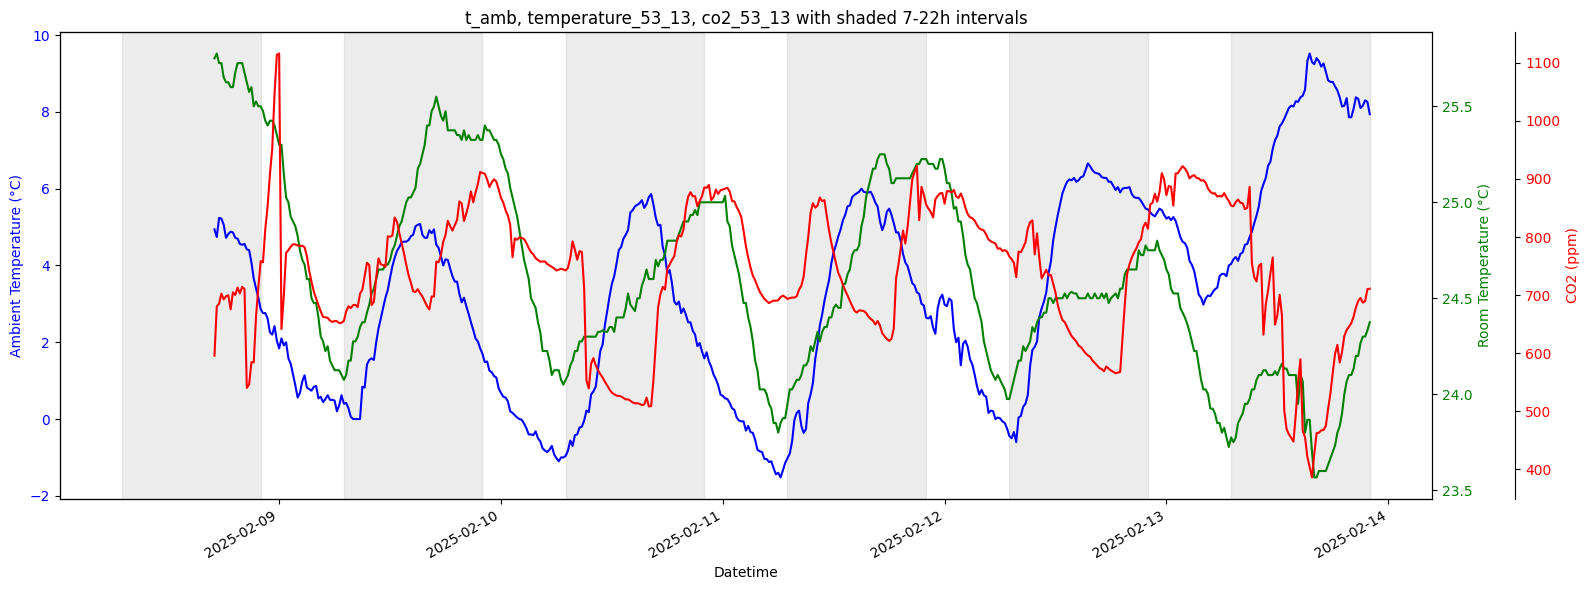

In [21]:
fig, ax1 = plt.subplots(figsize=(16, 6))

df_loc=location_groups['TPS Lamela L8'].copy()[8000:8500]

ax1.plot(df_loc.index, df_loc['t_amb'], label='t_amb', color='blue')
ax1.set_ylabel('Ambient Temperature (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

if 'temperature_53_13' in df_loc.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_loc.index, df_loc['temperature_53_13'], label='temperature_53_13', color='green')
    ax2.set_ylabel('Room Temperature (°C)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
else:
    ax2 = ax1

if 'co2_53_13' in df_loc.columns:
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(df_loc.index, df_loc['co2_53_13'], label='co2_53_13', color='red')
    ax3.set_ylabel('CO2 (ppm)', color='red')
    ax3.tick_params(axis='y', labelcolor='red')

start_date = df_loc.index.min().normalize()
end_date = df_loc.index.max().normalize()
current_date = start_date
while current_date <= end_date:
    start_time = pd.Timestamp(current_date.year, current_date.month, current_date.day, 7)
    end_time = pd.Timestamp(current_date.year, current_date.month, current_date.day, 22)
    ax1.axvspan(start_time, end_time, color='grey', alpha=0.15)
    current_date += pd.Timedelta(days=1)

ax1.set_xlabel('Datetime')
ax1.set_title('t_amb, temperature_53_13, co2_53_13 with shaded 7-22h intervals')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

How similar are ambient temperature readings across blocks? We need to explain why there are so big differences.

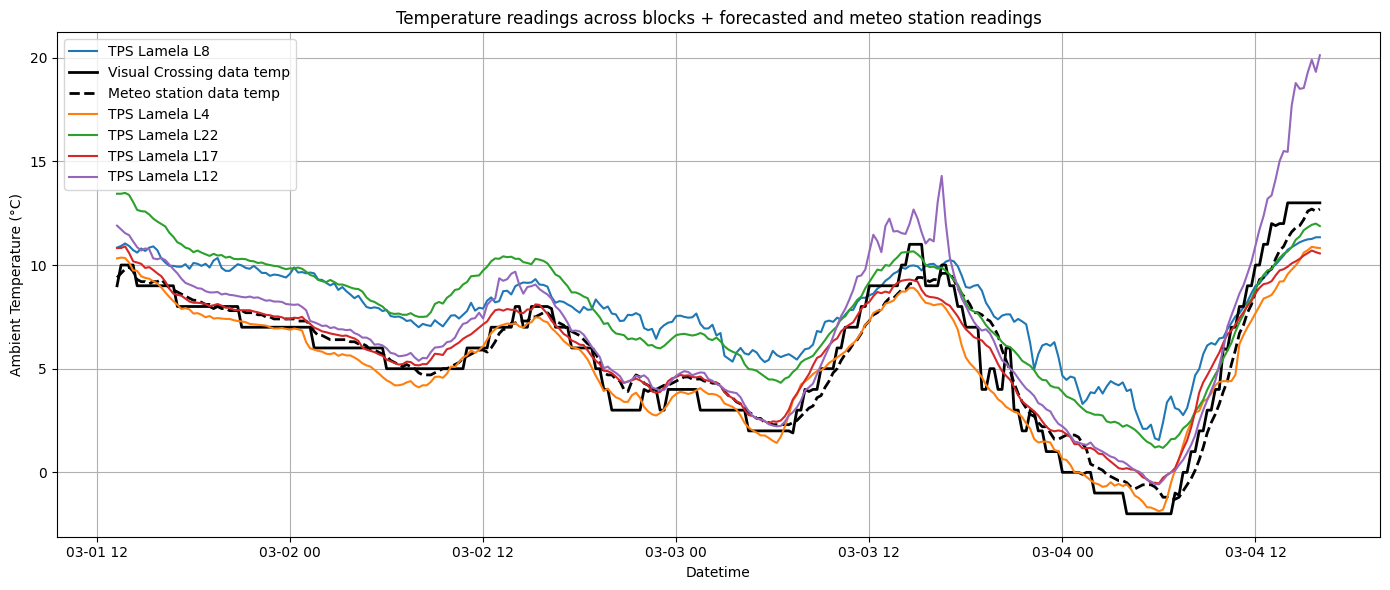

In [17]:
plt.figure(figsize=(14, 6))
plot_temp=True
for loc, df_loc in location_groups.items():
    df_loc=df_loc[10000:10300]
    plt.plot(df_loc.index, df_loc['t_amb'], label=loc)

    if(plot_temp):
        plt.plot(df_loc.index, df_loc['forecast_temp'], label='Visual Crossing data temp', linewidth=2, color='black')
        plt.plot(df_loc.index, df_loc['davis_temp'], label='Meteo station data temp', linewidth=2, color='black', linestyle='--')
        plot_temp=False

plt.xlabel('Datetime')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Temperature readings across blocks + forecasted and meteo station readings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot below is an illustration (zoomed in view to the data) showing the correlation between the ambient temperature readings at the selected substations and a heat load, with shaded areas between 7:00 and 22:00

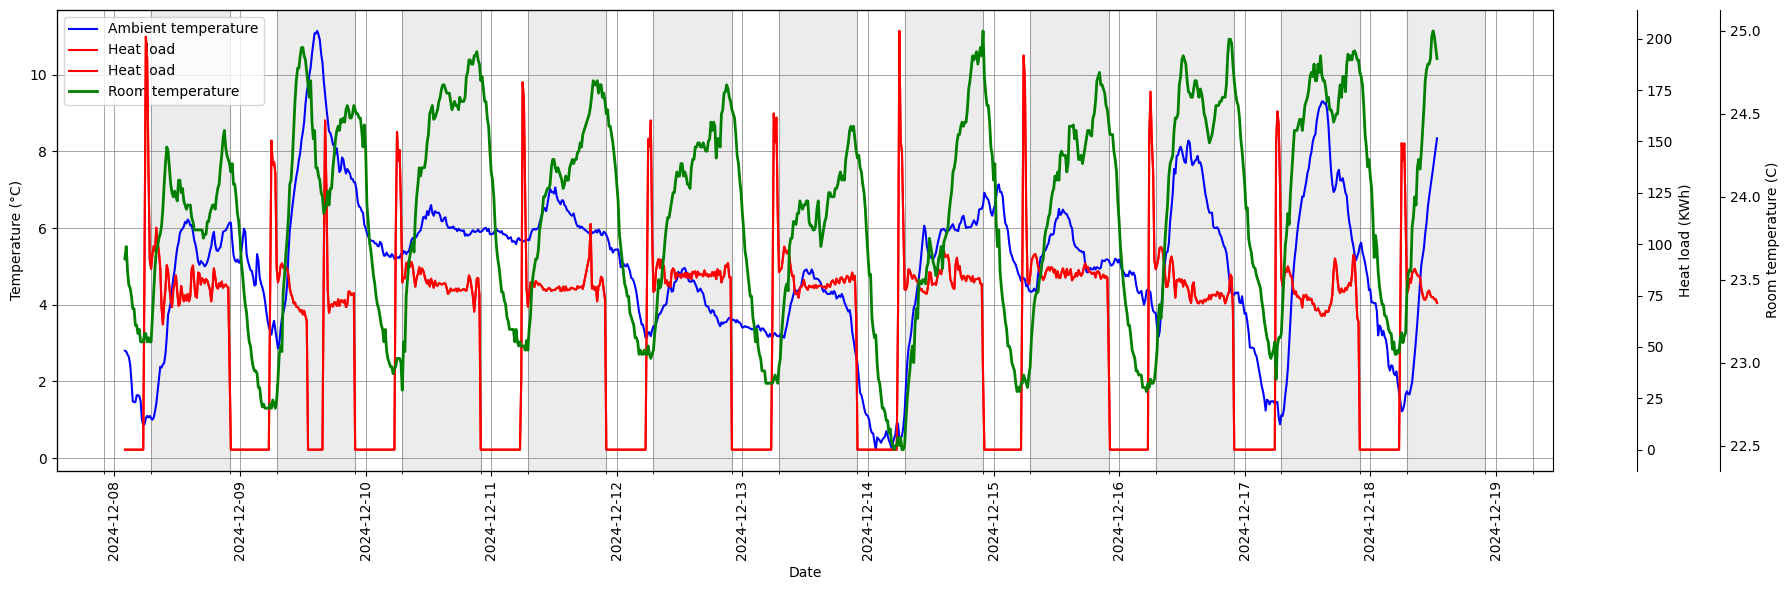

In [18]:
df=location_groups['TPS Lamela L17'][2000:3000]

fig, ax1 = plt.subplots(figsize=(18, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.plot(df.index, df['t_amb'], label='Ambient temperature', color='blue')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', rotation=90)

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Heat load (KWh)')
ax3.plot(df.index, df['qizm'], label='Heat load', color='red')
ax3.tick_params(axis='y')


ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.set_ylabel('Room temperature (C)')

temp_col = next(col for col in df.columns if col.startswith('temperature'))
ax4.plot(df.index, df[temp_col], label='Room temperature', color='green', linewidth=2)


ax3.plot(df.index, df['qizm'], label='Heat load', color='red')
ax3.tick_params(axis='y')


start_date = df.index.min().normalize()  # normalize to remove time from datetime
end_date = df.index.max().normalize()
current_date = start_date
while current_date <= end_date:
    start_time = pd.Timestamp(current_date.year, current_date.month, current_date.day, 7)
    end_time = pd.Timestamp(current_date.year, current_date.month, current_date.day, 22)
    ax1.axvspan(start_time, end_time, color='grey', alpha=0.15)
    current_date += pd.Timedelta(days=1)

# Formatting the x-axis
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=[7, 22]))
ax1.grid(True, which='both', linestyle='-', linewidth='0.5', color='gray')



lines1, labels1 = ax1.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()

ax1.legend(lines1 + lines3 + lines4, labels1 + labels3 + labels4)

fig.tight_layout()
plt.show()
